# ASE Genotype AI Summary



In [4]:
%run '../ipython_startup.py'

import cPickle as pkl
from sas7bdat import SAS7BDAT as SAS

Importing commonly used libraries: os, sys, numpy as np, scipy as sp, pandas as pd, matplotlib as mp, matplotlib.pyplot as plt, datetime as dt, mclib_Python/flagging as fg
Creating project level variables: MCLAB = /home/jfear/mclab, PROJ = /home/jfear/mclab/cegs_ase_paper, TODAY = 20150904
Adding ['scripts/mclib_Python', 'scripts/ase_Python'] to PYTHONPATH
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Import Data
with SAS(os.path.join(PROJ, 'sas_data/clean_ase_sbs.sas7bdat')) as FH:
    df = FH.to_data_frame()

# Import drop list from 100 genome simulation
toDrop = pkl.load(open(os.path.join(PROJ, 'pipeline_output/100_genome_simulation/exonic_region_drop_list.pkl'), 'rb'))

# Drop exonic regions in drop list
print 'Original DataFrame has {} rows'.format(df.shape[0])
df = df[-df['fusion_id'].isin(toDrop)].copy()
print 'After dropping DataFrame has {} rows'.format(df.shape[0])

[clean_ase_sbs.sas7bdat] header length 65536 != 8192
[clean_ase_sbs.sas7bdat] [clean_ase_sbs.sas7bdat] header length 65536 != 8192


Original DataFrame has 79967 rows
After dropping DataFrame has 79967 rows


In [6]:
# Get APN info for genotypes
with SAS(os.path.join(PROJ, 'sas_data/clean_ase_stack.sas7bdat')) as FH:
    apn = FH.to_data_frame()

apn_by_line = apn.groupby(['line', 'mating_status'])['mean_apn'].mean().unstack()
apn_by_line.columns = ['Mated APN', 'Virgin APN']

[clean_ase_stack.sas7bdat] header length 65536 != 8192
[clean_ase_stack.sas7bdat] [clean_ase_stack.sas7bdat] header length 65536 != 8192


In [7]:
# Make a bunch of flags for easy filtering
## Flag exons that have AI in both M and V 
df['flag_AI_both'] = 0
df.loc[(df['flag_AI_combined_m'] == 1) & (df['flag_AI_combined_v'] == 1), 'flag_AI_both'] = 1

## Flag exons that have AI in either M or V
df['flag_AI_either'] = 0
df.loc[(df['flag_AI_combined_m'] == 1) | (df['flag_AI_combined_v'] == 1), 'flag_AI_either'] = 1

## Flag AI in M only
df['m_only'] = 0
df.loc[(df['flag_AI_combined_m'] == 1) & (df['flag_AI_combined_v'] == 0), 'm_only'] = 1

## Flag AI in V only
df['v_only'] = 0
df.loc[(df['flag_AI_combined_m'] == 0) & (df['flag_AI_combined_v'] == 1), 'v_only'] = 1

In [8]:
# Get total number of exonic regions with AI
numFus = len(set(df[df['flag_AI_either'] == 1]['fusion_id'].values))
print('There were a total of {} exonic regions with AI'.format(numFus))

There were a total of 4090 exonic regions with AI


In [9]:
# Get total number of exonic regions with AI
numFusBoth = len(set(df[df['flag_AI_both'] == 1]['fusion_id'].values))
print('There were a total of {} exonic regions with AI in mated and virgin'.format(numFusBoth))

There were a total of 2712 exonic regions with AI in mated and virgin


In [10]:
# Summarize AI counts to the genotype level
AI = df.groupby('line')['flag_AI_either'].sum()
AI.name = 'flag_AI_either'

tested = df.groupby('line')['flag_AI_either'].count()
tested.name = 'num_tested'

pct = np.round(AI / tested * 100, decimals=2)
pct.name = 'percent'

AI_summary = pd.concat([AI, tested, pct], axis=1)


# Create Genotype Summary table with max and min counts and percents
## Do the calculations
genotype = list()
genotype.append(AI_summary.loc[AI_summary['flag_AI_either'].argmax()])
genotype.append(AI_summary.loc[AI_summary['flag_AI_either'].argmin()])
genotype.append(AI_summary.loc[AI_summary['percent'].argmax()])
genotype.append(AI_summary.loc[AI_summary['percent'].argmin()])

# Build the table
genotype_summary = pd.concat(genotype, axis=1).T
genotype_summary.reset_index(inplace=True)
genotype_summary.index = ['Max number of exons with AI', 'Min number of exons with AI', 'Max percent of exons with AI', 'Min percent of exons with AI']
genotype_summary.columns = ['Genotype', 'Number exons with AI', 'Number exons tested', 'Percent exons with AI']
genotype_summary.merge(np.round(apn_by_line, decimals=2), how='left', left_on='Genotype', right_index=True)

,Genotype,Number exons with AI,Number exons tested,Percent exons with AI,Mated APN,Virgin APN
Max number of exons with AI,w47,1244,3003,41.43,234.12,128.53
Min number of exons with AI,r21,143,608,23.52,116.74,91.90
Max percent of exons with AI,r857,486,886,54.85,155.64,222.24
Min percent of exons with AI,r380,236,2038,11.58,128.07,120.69


count    49.000000
mean     27.186327
std       9.633105
min      11.580000
25%      19.850000
50%      25.170000
75%      33.330000
max      54.850000
Name: percent, dtype: float64

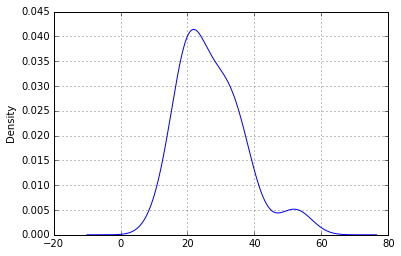

In [11]:
# Distribution of percent AI
AI_summary['percent'].plot(kind='kde')
AI_summary['percent'].describe()

In [12]:
# Genotype discordance
## Indicator up down M q5
df['ind_m_05'] = 0
df.loc[df['q5_mean_theta_m'] > 0.5, 'ind_m_05'] = 'Mated towards tester'
df.loc[df['q5_mean_theta_m'] < 0.5, 'ind_m_05'] = 'Mated towards line'

## Indicator up down V q5
df['ind_v_05'] = 0
df.loc[df['q5_mean_theta_v'] > 0.5, 'ind_v_05'] = 'Virgin towards tester'
df.loc[df['q5_mean_theta_v'] < 0.5, 'ind_v_05'] = 'Virgin towards line'

mated_discord = df[df['flag_AI_both'] == 1].groupby(['fusion_id', 'ind_m_05']).size().unstack().dropna()
mated_discord['Mated total'] = mated_discord.sum(axis=1)

virgin_discord = df[df['flag_AI_both'] == 1].groupby(['fusion_id', 'ind_v_05']).size().unstack().dropna()
virgin_discord['Virgin total'] = virgin_discord.sum(axis=1)

genotype_discord = mated_discord.join(virgin_discord, how='outer')
display(genotype_discord.head())
print('There is a total of {} exonic regions with some evidence of discordance.'.format(genotype_discord.shape[0]))
print('{} exonic regions have at least 10 genotypes in mated'.format((genotype_discord['Mated total'] >= 10).sum()))
print('{} exonic regions have at least 10 genotypes in virgin'.format((genotype_discord['Virgin total'] >= 10).sum()))

genotype_discord.to_excel(os.path.join(PROJ, 'pipeline_output/ase_summary/genotype_discordance.xls'))

,Mated towards line,Mated towards tester,Mated total,Virgin towards line,Virgin towards tester,Virgin total
fusion_id,,,,,,
F10060_SI,4,3,7,4,3,7
F10136_SI,1,3,4,1,3,4
F10268_SI,1,3,4,1,3,4
F10523_SI,NaN,NaN,NaN,1,1,2
F11773_SI,3,2,5,3,2,5


There is a total of 548 exonic regions with some evidence of discordance.
112 exonic regions have at least 10 genotypes in mated
118 exonic regions have at least 10 genotypes in virgin


In [19]:
both_discord = genotype_discord[(genotype_discord['Mated total'] >= 10) & (genotype_discord['Virgin total'] >= 10)]
print both_discord.shape[0]
both_discord.sort('Mated total')

112


,Mated towards line,Mated towards tester,Mated total,Virgin towards line,Virgin towards tester,Virgin total
fusion_id,,,,,,
F13385_SI,5,5,10,6,4,10
S37763_SI,2,8,10,2,8,10
F62997_SI,2,8,10,2,8,10
S11514_SI,8,2,10,8,2,10
S13372_SI,4,6,10,4,6,10
F53196_SI,9,1,10,9,1,10
F46859_SI,8,2,10,8,2,10
F46432_SI,4,6,10,5,5,10
S4199_SI,1,9,10,2,8,10


In [13]:
# Flag AI in both, but theta in different directions Environment
df['diff_direction_env'] = 0
df.loc[(df['flag_AI_combined_m'] == 1) & (df['flag_AI_combined_v'] == 1) & 
       (((df['q5_mean_theta_m'] > 0.5) & (df['q5_mean_theta_v'] < 0.5)) | ((df['q5_mean_theta_m'] < 0.5) & (df['q5_mean_theta_v'] > 0.5))), 
       'diff_direction_env'] = 1